<a href="https://colab.research.google.com/github/hildermesmedeiros/ImersaoAluraGoogleIA2024/blob/main/AluraIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando


In [ ]:
!pip install -q -U folium
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 1.2 MB/s eta 0:00:00


# Ideia
### Como cartógrafo e Dev E funcionário de uma empresa de Geotech, pretendo extrair coordenadas de imagens com tabelas e georeferencia-las.


### Já fiz diversos scripts parecidos com ocr, lendo, pdf, world.
### E demandam muito código e regex.

# Que o Gemini nos ajude!

# Imports iniciais

In [ ]:
from google.colab import userdata
from pathlib import Path
import hashlib
import google.generativeai as genai
import pandas as pd
import numpy as np

In [ ]:
import pyproj
from pyproj import CRS
from pyproj.database import CRSInfo
from pyproj import Transformer

In [ ]:
import folium

In [ ]:
from typing import List, Tuple, Optional

# Classe para filtrar projeções, pretendo limitar as projeções do brasil

# Também usarei embedding para garantir que não alucine com as projeções

In [ ]:
import pyproj
from pyproj import database

class DatumFilter:
    def __init__(self, filter_keywords: List[str]):
        """
        Initialize the DatumFilter class with specific keywords to filter CRS names.

        Args:
        filter_keywords (List[str]): Keywords to search for within CRS names.
        """
        self.filter_keywords: List[str] = filter_keywords
        self.datums_list: List[Dict[str, str]] = []

    def query_datums(self) -> None:
        """
        Query and filter CRS information from the pyproj database based on initialized keywords.
        """
        crs_list: List[CRSInfo] = pyproj.database.query_crs_info(allow_deprecated=False)
        for crs_info in crs_list:
            if any(keyword in crs_info.name for keyword in self.filter_keywords):
                self.datums_list.append({'crs_code': crs_info.code, 'crs_name': crs_info.name})

    def get_datums(self) -> pd.DataFrame:
        """
        Get the filtered list of datum information as a Pandas DataFrame.

        Returns:
        pd.DataFrame: DataFrame with 'crs_code' and 'crs_name' columns.
        """
        return pd.DataFrame(self.datums_list)

# Usage of DatumFilter class
filter_keywords = ["SIRGAS 2000", "SAD"]
datum_filter = DatumFilter(filter_keywords)
datum_filter.query_datums()
df = datum_filter.get_datums()
df

,crs_code,crs_name
0,2317,PSAD56 / ICN Regional
1,4248,PSAD56
2,4618,SAD69
3,4674,SIRGAS 2000
4,4988,SIRGAS 2000
...,...,...
67,31981,SIRGAS 2000 / UTM zone 21S
68,31982,SIRGAS 2000 / UTM zone 22S
69,31983,SIRGAS 2000 / UTM zone 23S
70,31984,SIRGAS 2000 / UTM zone 24S


In [ ]:
gemin_api_key = userdata.get('geminiapi')

# Classe para printar os poligonos extraido das tabelas em uma mapa, para comparar com o dado real

In [ ]:
from abc import ABC, abstractmethod
from typing import List, Tuple, Optional
import folium
from pyproj import Transformer

class MapManagerABC(ABC):
    """Abstract Base Class for map management."""

    @abstractmethod
    def add_polygons_to_map(self):
        """Add polygons to the map."""
        pass

    @abstractmethod
    def show_map(self):
        """Display the map."""
        pass

    @abstractmethod
    def transform_coordinates(self, polygon_data: dict) -> List[List[Tuple[float, float]]]:
        """Transform coordinates from one spatial reference system to another."""
        pass

class FoliumMapManager(MapManagerABC):
    """Concrete implementation of a map manager using Folium."""

    def __init__(self,
                 polygon_data_list: List[dict],
                 initial_map_location: Optional[List[float]] = None,
                 zoom_start: int = 15,
                 width: str = '600px',
                 height: str = '600px',
                 attr: str = "#Alura #Google #Gemini"
                 ):
        self.attr = attr
        self.polygon_data_list = polygon_data_list
        self.map = folium.Map(
            location=initial_map_location or [0, 0],
            zoom_start=zoom_start,
            tiles=None
        )

        self.figure = folium.Figure(width=width, height=height)
        self.map.add_to(self.figure)
        self.add_base_maps()

    def transform_coordinates(self, polygon_data: dict) -> List[List[Tuple[float, float]]]:
        """Transform polygon coordinates from a specified spatial reference to WGS84 (latitude, longitude)."""
        transformer = Transformer.from_crs(f"epsg:{polygon_data['spatialReference']['wkid']}", "epsg:4326", always_xy=True)
        transformed_coordinates = [
            [(transformer.transform(x, y)[1], transformer.transform(x, y)[0]) for x, y in ring] for ring in polygon_data['rings']
        ]
        return transformed_coordinates

    def add_polygons_to_map(self) -> None:
        """Add polygons to the map with interactive features."""
        for idx, polygon_data in enumerate(self.polygon_data_list, start=1):
            transformed_coordinates = self.transform_coordinates(polygon_data)
            feature_group = folium.FeatureGroup(name=f"Polygon {idx}")
            folium.Polygon(
                locations=[[coord for coord in ring] for ring in transformed_coordinates],
                color='blue',
                fill=True,
                fill_color='blue',
                popup=f"Polygon {idx}"
            ).add_to(feature_group)
            feature_group.add_to(self.map)
        folium.LayerControl().add_to(self.map)

    def add_base_maps(self):
        """Add different tile layers to the map, including necessary attributions."""
        # Default tiles with their default attributions
        folium.TileLayer('OpenStreetMap', attr=self.attr).add_to(self.map)
        folium.TileLayer('CartoDB positron', attr=self.attr).add_to(self.map)
        folium.TileLayer('CartoDB dark_matter', attr=self.attr).add_to(self.map)

    def show_map(self) -> folium.Map:
        """Show the map, centering on the first polygon if possible."""
        if self.map.location == [0, 0] and self.polygon_data_list:
            first_polygon_coords = self.transform_coordinates(self.polygon_data_list[0])[0][0]
            self.map.location = first_polygon_coords
        return self.map

# Embed dos datums, se os datums não tiverem seus identificadores únicos corretamente identificados, cairam no lugar errado!

In [ ]:
from abc import ABC, abstractmethod
from typing import Any, Dict

class EmbedMaker(ABC):
    """
    Abstract Base Class for creating embeddings using a generic AI model.
    """
    @abstractmethod
    def __init__(self, model: Any):
        """
        Initialize with a model. All subclasses must override this method to ensure
        proper initialization with specific model configurations or parameters.
        """
        self.model = model

    @abstractmethod
    def embed_row(self, title: str, text: str) -> Dict[str, Any]:
        """
        Method to create embeddings for given title and text.
        Must be implemented by all subclasses.
        """
        pass

class GenAIEncoder(EmbedMaker):
    """
    Concrete implementation of EmbedMaker using the hypothetical genai.embed_content function.
    """
    def __init__(self, model: Any='models/embedding-001'):
        super().__init__(model)

    def embed_row(self, title: str, text: str) -> Dict[str, Any]:
        genai.configure(api_key=userdata.get('geminiapi'))
        return genai.embed_content(model=self.model,
                                   content=text,
                                   title=title,
                                   task_type='RETRIEVAL_DOCUMENT')['embedding']

    def query_embed(self, query: str, base: pd.DataFrame, col_name: str = 'crs_code'):
      embedding_da_consulta = genai.embed_content(model=self.model,
                                              content=query,
                                              task_type='RETRIEVAL_QUERY') ['embedding']

      produtos_escalares = np.dot(np.stack(base['embeddings']), embedding_da_consulta)
      indice_da_maior_similaridade_de_contexto = np.argmax(produtos_escalares)
      return base.iloc[indice_da_maior_similaridade_de_contexto][col_name]

In [ ]:
gen_ai_encode = GenAIEncoder()

In [ ]:
df['embeddings'] = df.apply(lambda row: gen_ai_encode.embed_row(content=row['crs_name'], title=row['crs_code']), axis=1)
df

,crs_code,crs_name,embeddings
0,2317,PSAD56 / ICN Regional,"[0.06142234, -0.02703049, -0.05860492, -0.0047..."
1,4248,PSAD56,"[0.04671155, -0.037813984, -0.0857377, -0.0078..."
2,4618,SAD69,"[0.04702406, -0.05705927, -0.09442449, 0.01987..."
3,4674,SIRGAS 2000,"[0.057671193, -0.026782347, -0.107674524, -0.0..."
4,4988,SIRGAS 2000,"[0.03681696, -0.038837604, -0.0922596, -0.0024..."
...,...,...,...
67,31981,SIRGAS 2000 / UTM zone 21S,"[0.03337009, -0.038692247, -0.066435345, -0.02..."
68,31982,SIRGAS 2000 / UTM zone 22S,"[0.037629567, -0.03670813, -0.07892794, -0.032..."
69,31983,SIRGAS 2000 / UTM zone 23S,"[0.050586924, -0.041410793, -0.07294711, -0.03..."
70,31984,SIRGAS 2000 / UTM zone 24S,"[0.05875516, -0.03321022, -0.07671628, -0.0320..."


### "Tchau alucinação"

In [ ]:
gen_ai_encode.query_embed(query="Sirg 2000 24S", base=df)

'31984'

# Imagens base
# crei o json dos arquivos na mão extraindo da tabela
# Fiz só dois exemplos

esperança baixa, mas um bom dev confia no processo!

In [ ]:
from IPython.display import Image

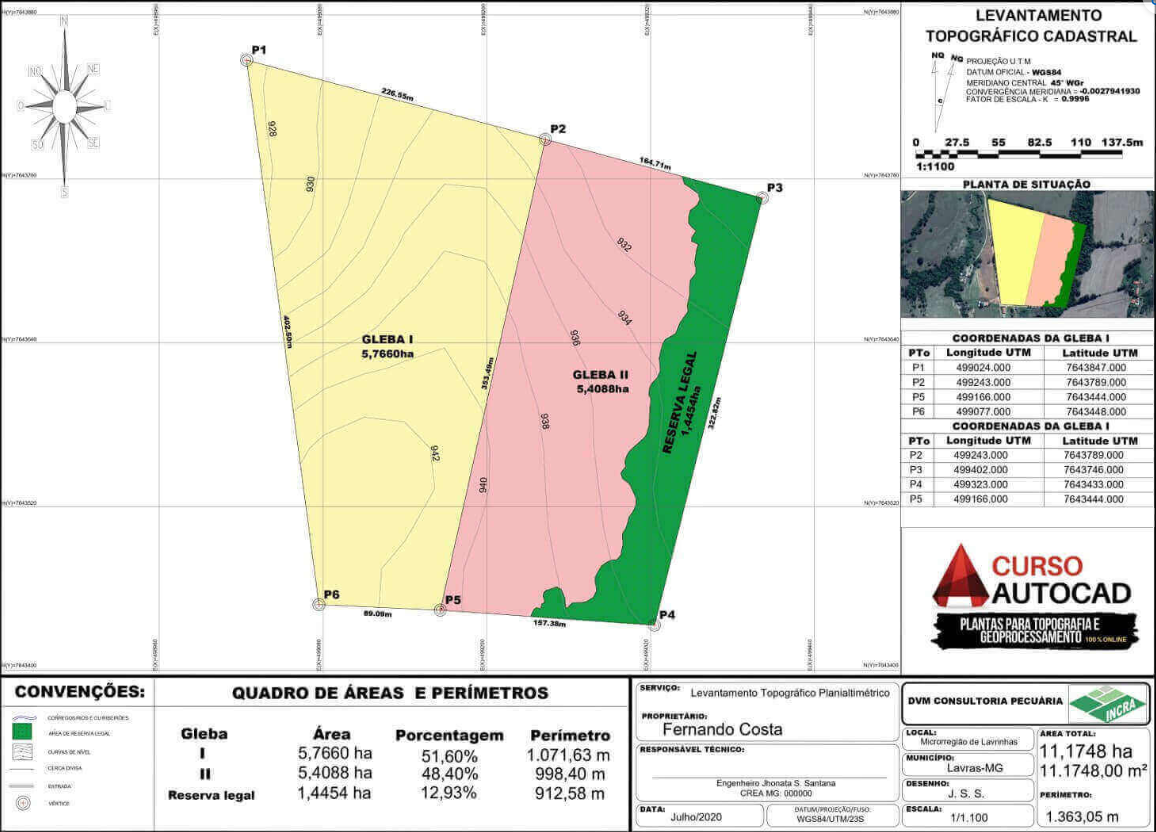

In [ ]:
file_path1=r'/content/drive/MyDrive/Google AI Studio/Prompt Pasted Image - 1a430c154322821922376f6d412eb08ecef74666c9970d2047a4cd22bf58ce86.png'
Image(file_path1)

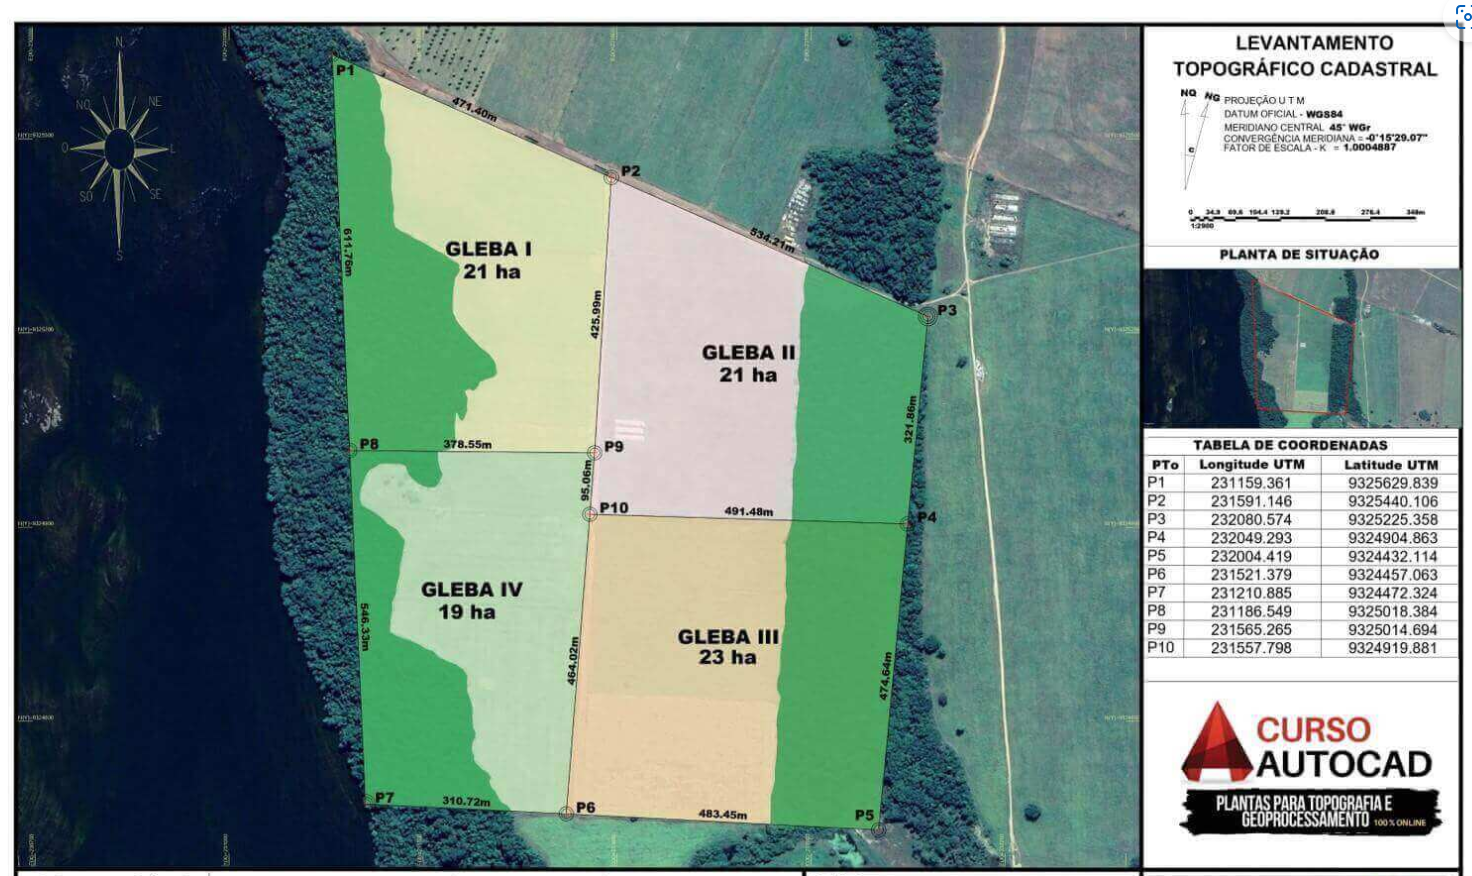

In [ ]:
file_path2= r'/content/drive/MyDrive/Google AI Studio/Prompt Pasted Image - 006bf176107133b831563fcc5540060d89dbaf75408f0e8f2c42f7e70de04818.png'
Image(file_path2)

# A imagem maligna!!!! Que ele deve extrair as coordenadas!
# Reparem que separador de milhar é `.` e decimal `,`

## `o que sera que nosso padawan fará!`

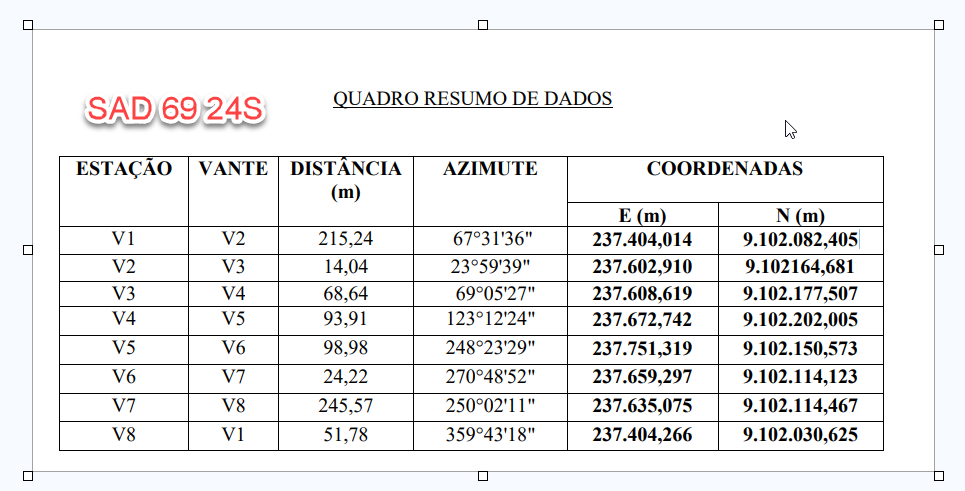

In [ ]:
input_path1 = "/content/drive/MyDrive/Google AI Studio/Prompt Pasted Image - 331c18814d39b5341d19ae02b5789ad34c5d7870b76b4ef049e8cfc37e69e6f2.png"
Image(input_path1)

# E aqui começa nossa jornada

In [ ]:
genai.configure(api_key=userdata.get('geminiapi'))

# Set up the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 0,
  "max_output_tokens": 8192,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
]

model = genai.GenerativeModel(model_name="gemini-1.5-pro-latest",
                              generation_config=generation_config,
                              safety_settings=safety_settings)

ajuda_do_bem_ou_nao = '''\n\n
As coordenadas podem estar com .
ou virgulas para separar a casa do milhar em pt ou ingles.
237.404,014 9.102.082,405
237,404.014 9,102,082.405
237404.014 9102082.405
237404,014 9102082,405
237404.014 9102082,405
237404,014 9102082.405
Que seriam equivalentes a mesma
237404.014 9102082.405'''
prompt_parts = [
  f"{df[['crs_code',	'crs_name']].to_string(index=False)} {ajuda_do_bem_ou_nao}",
  "input: ",
  genai.upload_file(file_path1),
  "​",
  "output: [\n    {\n        \"rings\": [\n            [\n                [\n                    499024,\n                    7643847\n                ],\n                [\n                    499243,\n                    7643789\n                ],\n                [\n                    499166,\n                    7643444\n                ],\n                [\n                    499077,\n                    7643448\n                ],\n                [\n                    499024,\n                    7643847\n                ]\n            ]\n        ],\n        \"spatialReference\": {\n            \"wkid\": 32723\n        }\n    },\n    {\n        \"rings\": [\n            [\n                [\n                    499243,\n                    7643789\n                ],\n                [\n                    499402,\n                    7643746\n                ],\n                [\n                    499323,\n                    7643434\n                ],\n                [\n                    499166,\n                    7643433\n                ],\n                [\n                    499243,\n                    7643789\n                ]\n            ]\n        ],\n        \"spatialReference\": {\n            \"wkid\": 32723\n        }\n    }\n]",
  "output 2: O datum é:\nEPSG:32723 WGS 84 / UTM zone 23S",
  "input: ",
  genai.upload_file(file_path2),
  "​",
  "output: [\n    {\n        \"rings\": [\n            [\n                [\n                    231159.361,\n                    9325629.839\n                ],\n                [\n                    231591.146,\n                    9325440.106\n                ],\n                [\n                    232080.574,\n                    9325225.358\n                ],\n                [\n                    232049.293,\n                    9324904.863\n                ],\n                [\n                    232004.419,\n                    9324432.114\n                ],\n                [\n                    231521.379,\n                    9324457.063\n                ],\n                [\n                    231210.885,\n                    9324472.324\n                ],\n                [\n                    231186.549,\n                    9325018.384\n                ],\n                [\n                    231565.265,\n                    9325014.694\n                ],\n                [\n                    231557.798,\n                    9324910.881\n                ],\n                [\n                    231159.361,\n                    9325629.839\n                ]\n            ]\n        ],\n        \"spatialReference\": {\n            \"wkid\": 32723\n        }\n    }\n]",
  "output 2: O datum é:\nEPSG:32723 WGS 84 / UTM zone 23S",
  "input: ",
  genai.upload_file(input_path1),
  "​",
  "output: ",
  "output 2: ",
]

response = model.generate_content(prompt_parts)
print(response.text)

O datum é:
SAD 69 / UTM zone 24S 

Os poligonos são:
```json
[
  {
    "rings": [
      [
        [
          237404.014,
          9102082.405
        ],
        [
          237602.910,
          9102164.681
        ],
        [
          237608.619,
          9102177.507
        ],
        [
          237672.742,
          9102202.005
        ],
        [
          237751.319,
          9102150.573
        ],
        [
          237659.297,
          9102114.123
        ],
        [
          237635.075,
          9102114.467
        ],
        [
          237404.266,
          9102030.625
        ],
        [
          237404.014,
          9102082.405
        ]
      ]
    ],
    "spatialReference": {
      "wkid": 29194
    }
  }
]
```


### Eu sei oq que fazer, tenho que usar regex para separar esses dois
### ou alguma lógica

# Adivinha que pode me ajudar?

dica: não é o chapolin

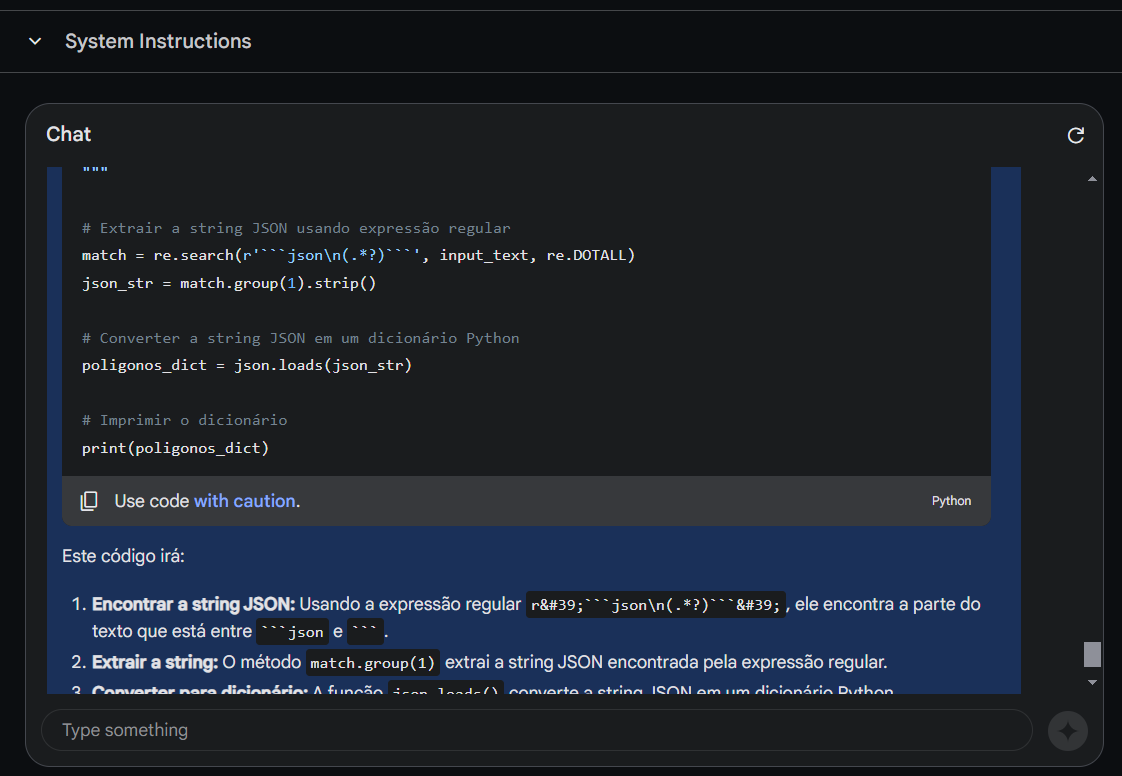

In [ ]:
import re
# Expressão regular para encontrar "Datum é: <datum>"
regex = r"O datum é:\n(.*)"

# Encontrar a correspondência no texto
match = re.search(regex, response.text)

# Extrair o datum
datum = match.group(1).strip() if match else None
datum

'SAD 69 / UTM zone 24S'

In [ ]:
datum_mais_provavel = gen_ai_encode.query_embed(query=datum, base=df)
datum_mais_provavel

'29194'

In [ ]:
import json

In [ ]:
# Extrair a string JSON usando expressão regular
match = re.search(r'```json\n(.*?)```', response.text, re.DOTALL)
json_str = match.group(1).strip()

# Lista de poligonos
poligonos_list = json.loads(json_str)
poligonos_list

[{'rings': [[[237404.014, 9102082.405],
    [237602.91, 9102164.681],
    [237608.619, 9102177.507],
    [237672.742, 9102202.005],
    [237751.319, 9102150.573],
    [237659.297, 9102114.123],
    [237635.075, 9102114.467],
    [237404.266, 9102030.625],
    [237404.014, 9102082.405]]],
  'spatialReference': {'wkid': 29194}}]

# Nossa embeding serviu aqui, se datum se perder, cai no lugar errado!

In [ ]:
for pol in poligonos_list:
  pol['spatialReference']['wkid'] = datum_mais_provavel

# É incrível, sem palavras

In [ ]:
manager = FoliumMapManager(poligonos_list)
manager.add_polygons_to_map()
m = manager.show_map()
display(m)

# Obrigado Alura, Google pela imersão.
Foi divertido!!!

Abraços aos meus colegas de profissão!

beijo vidão (Michele)!  
tchauu!